# Compute the iron sediment forcing (`fedsedflux`) supplied to the model

This notebook implements an approach to computing `fesedflux` originally in an IDL routine by J. K. Moore.

`fesedflux` includes two components:
- `fesedflux_oxic`: a constant low background value; increased in regions of high bottom horizontal current speed (sediment resuspenion) by up to a factor of 100.
- `fesedflux_reduce`: source everywhere linearly related to the sinking POC flux by `coef_fesedflux_POC_flux`, except: 
  - source is zero below `POC_flux_gCm2yr_min` (3 gC m$^{-2}$ yr$^{-1}$ in CESM2), and 
  - constant above `POC_flux_gCm2yr_max`.
  - This puts a source on the shelf, and along productive slope/margins, but has little source in the deep ocean, where almost all the remineralization is oxic right on the sediment surface.

`fesedflux` is computed on subgrid-scale bathymetry, using the fraction of each cell that is ocean bottom at each depth: `fesedfrac`. `fesedfrac` is [computed from ETOPO1 bathymetry](sedfrac_compute.ipynb) and modified as follows:
- a minimum percentage of each grid cell that is sediments (`land_adj_sedfrac_min`) is applied to all land-adjacent grid cells.


**Arbitrary modification to this objective scheme:**
- `fesedflux_reduce` is multiplied by 10 in the western equatorial Pacific (135-200E, 15S-15N, above 504 m). 


## Procedure

1. Prepare `fesedfrac`:
   - Read pre-computed [`fesedfrac`](sedfrac_compute.ipynb);
   - Determine land-adjascent points;
   - Create `sedfrac_mod` by applying `land_adj_sedfrac_min`.


2. Compute `fesedflux_reduce`:
   - Read `POC_flux` and convert units; 
   - Where `POC_flux < POC_flux_gCm2yr_min, POC_flux = 0.`;
   - Where `POC_flux > POC_flux_gCm2yr_max, POC_flux = POC_flux_gCm2yr_max`
   - `fesedflux_reduce = POC_flux * coef_fesedflux_POC_flux * sedfrac_mod`
   - Apply ad hoc scaling in to select regions.


3. Compute `fesedflux_oxic`:
   - Read `UVEL` and `VVEL` and compute `current_speed`
   - Where `current_speed < 1.0: current_speed = 1.0`
   - Where `current_speed > 10.0: current_speed = 10.0` 
   - `fesedflux_oxic = coef_fesedflux_current_speed * sedfrac_mod * current_speed**2`
   

4. Output `fesedflux_oxic` and `fesedflux_reduce` in model units: µmol/m^2/d
   

## Preliminary setup

In [1]:
%matplotlib inline
import os
import tqdm
import yaml
from itertools import product

from datetime import date, datetime, timezone

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import esmlab
import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
id_string = 'Fe_sediment_flux_forcing.ipynb from github.com/marbl-ecosys/forcing-Fe-sedflux'

mol_per_nmol = 1e-9 
mol_per_µmol = 1e-6
mol_per_mmol = 1e-3
mol_per_Gmol = 1e9
gC_per_mol = 12.011 
cm2_per_m2 = 1e4 
d_per_yr = 365.0
s_per_yr = d_per_yr * 86400.0
nmolCcm2s_to_gCm2yr = mol_per_nmol * gC_per_mol * cm2_per_m2 * s_per_yr
mmolCm2d_to_gCm2yr = mol_per_mmol * gC_per_mol * d_per_yr
mmolm2yr_to_µmolm2d = 1. / d_per_yr / mol_per_µmol * mol_per_mmol

### Specify model grid and associated parameters

In [3]:
dst_grid = 'POP_tx0.1v3'

In [4]:
# Parameters
dst_grid = "POP_gx1v7"


In [5]:
POC_flux_gCm2yr_max = 20.
POC_flux_gCm2yr_min = 3.

current_speed_min = 1.   # cm/s
current_speed_max = 10.  # cm/s

western_pacific_factor = 10. # scale Fe flux in W. Pacific

data_in_src_grid = dict(poc_flux='POP_gx1v7', velocity='POP_gx1v7')

i_pacific = util.nlon_pacific_xsection[dst_grid]
j_acc = util.nlat_acc_xsection[dst_grid]

   
if dst_grid == 'POP_gx3v7':
    land_adj_sedfrac_min = 0.015
    coef_fesedflux_POC_flux = 0.01584 # (mmolFe/m^2/yr)/(gC/m^2/yr)
    coef_fesedflux_current_speed2 = 0.0008405    
    ltripole = False

elif dst_grid == 'POP_gx1v7':    
    land_adj_sedfrac_min = 0.03
    coef_fesedflux_POC_flux = 0.01614 # (mmolFe/m^2/yr)/(gC/m^2/yr) #  * 1.6
    coef_fesedflux_current_speed2 = 0.0006568 # * 1.2
    ltripole = False
    
elif dst_grid == 'POP_tx0.1v3':
    land_adj_sedfrac_min = 0.2
    coef_fesedflux_POC_flux = 0.018 # (mmolFe/m^2/yr)/(gC/m^2/yr)
    coef_fesedflux_current_speed2 = 0.0005
    ltripole = True
    data_in_src_grid['velocity'] = 'POP_tx0.1v3'

data_in_src_grid    

{'poc_flux': 'POP_gx1v7', 'velocity': 'POP_gx1v7'}

### Get model data `POC_FLUX_IN`, `UVEL`, `VVEL`

In [6]:
ds = pop_tools.get_grid(dst_grid)

for var_group, src_grid in data_in_src_grid.items():
    zarr_in = f'{util.dirwork}/{var_group}.{src_grid}_to_{dst_grid}.zarr'
    print(f'reading {zarr_in}')
    with xr.open_zarr(zarr_in) as dsv:
        dsv = dsv.drop([v for v in dsv.variables if v not in ['POC_FLUX_IN', 'UVEL', 'VVEL']]).load()
        ds = xr.merge((ds, dsv))

ds

reading /glade/work/mclong/cesm_inputdata/work/poc_flux.POP_gx1v7_to_POP_gx1v7.zarr


reading /glade/work/mclong/cesm_inputdata/work/velocity.POP_gx1v7_to_POP_gx1v7.zarr


<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    POC_FLUX_IN  (z_t, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    UVEL         (z_t, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVEL         (z_t, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

### Read `sedfrac` and apply `land_adj_sedfrac_min`

In [7]:
with xr.open_dataset(util.sedfrac_file(dst_grid)) as dstmp:
    sedfrac = dstmp.sedfrac.reset_index('z_t', drop=True).compute()
        
land_adjacent = util.compute_topo_adjacent_points(dst_grid)

sedfrac_mod = util.apply_topo_adj_sedfrac_min(
    sedfrac,
    land_adjacent,
    land_adj_sedfrac_min,
)

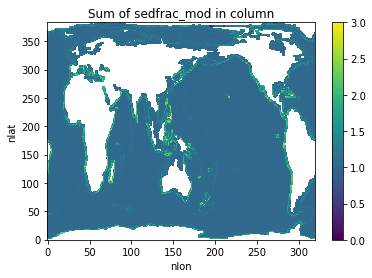

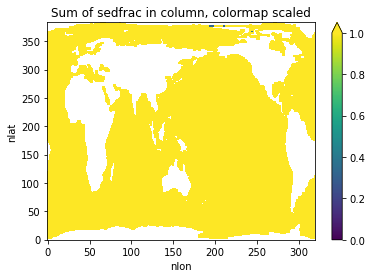

In [8]:
plt.figure()
sedfrac_mod.sum('z_t').where(ds.KMT > 0).plot(vmin=0, vmax=3.) 
h = plt.title('Sum of sedfrac_mod in column')

plt.figure()
sedfrac_mod.sum('z_t').where(ds.KMT > 0).plot(vmin=0, vmax=1.) 
h = plt.title('Sum of sedfrac in column, colormap scaled')

## Compute `fesedflux_reduce`

### Prepare `POC_flux`: 
- convert units
- Where `POC_flux < POC_flux_gCm2yr_min, POC_flux = 0.`; 
- Where `POC_flux > POC_flux_gCm2yr_max, POC_flux = POC_flux_gCm2yr_max`

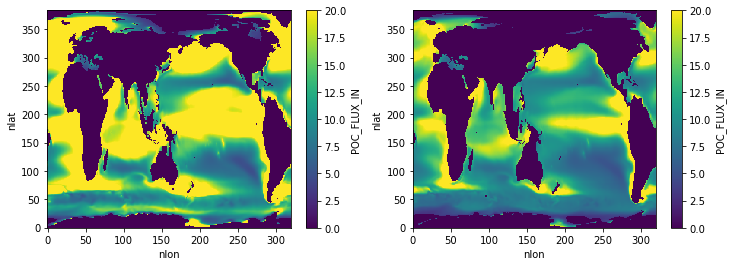

In [9]:
POC_flux = ds.POC_FLUX_IN * nmolCcm2s_to_gCm2yr
POC_flux = xr.where(POC_flux <= POC_flux_gCm2yr_min, 0., POC_flux)
POC_flux = xr.where(POC_flux > POC_flux_gCm2yr_max, POC_flux_gCm2yr_max, POC_flux)
POC_flux = POC_flux.reset_index('z_t', drop=True)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
h = POC_flux.isel(z_t=3).plot()

ax = fig.add_subplot(1, 2, 2)
h = POC_flux.isel(z_t=20).plot()

### Compute `fesedflux_reduce`

Compute and apply ad hoc scaling in to select regions

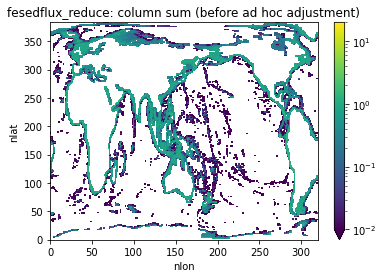

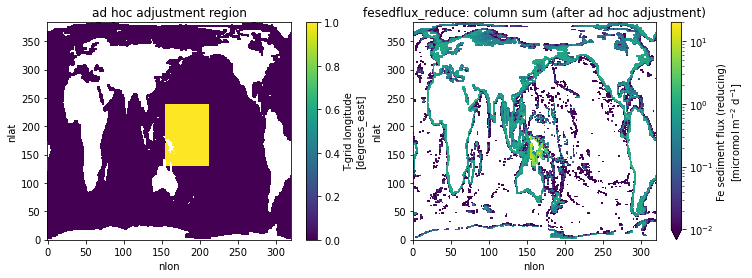

In [10]:
# initial computation
fesedflux_reduce = coef_fesedflux_POC_flux * POC_flux * sedfrac_mod
fesedflux_reduce = fesedflux_reduce.fillna(0.)

fesedflux_reduce = fesedflux_reduce * mmolm2yr_to_µmolm2d

# plot initial values
plt.figure()
fesedflux_reduce.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))
h = plt.title('fesedflux_reduce: column sum (before ad hoc adjustment)')

# apply ad hoc adjustments
region_def = ((134. <= ds.TLONG) & (ds.TLONG <= 200) 
              & (np.fabs(ds.TLAT) <= 15) & (ds.z_t <= 450e2))

region_def = region_def.where(ds.KMT > 0).reset_index('z_t', drop=True)
region_def = region_def.transpose('z_t', 'nlat', 'nlon')

fesedflux_reduce = xr.where(region_def==1, fesedflux_reduce * western_pacific_factor, fesedflux_reduce)
fesedflux_reduce.name = 'Fe sediment flux (reducing)'
fesedflux_reduce.attrs['units'] = 'micromol m$^{-2}$ d$^{-1}$'


fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
region_def.isel(z_t=0).plot()
h = plt.title('ad hoc adjustment region')

ax = fig.add_subplot(1, 2, 2)
fesedflux_reduce.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))
h = plt.title('fesedflux_reduce: column sum (after ad hoc adjustment)')

### Report global integral 

In [11]:
fesedflux_reduce_global = esmlab.statistics.weighted_sum(fesedflux_reduce, weights=ds.TAREA/cm2_per_m2, 
                                                         dim=('nlat', 'nlon')).sum('z_t')

fesedflux_reduce_global = fesedflux_reduce_global * mol_per_µmol / mol_per_Gmol * d_per_yr
print(f'Global integral of `fesedflux_reduce_global` = {fesedflux_reduce_global.values:0.4f} Gmol Fe/yr')


Global integral of `fesedflux_reduce_global` = 13.5882 Gmol Fe/yr


## Compute `fesedflux_oxic`

- Read `UVEL` and `VVEL` and compute `current_speed`
- Where `current_speed < current_speed_min: current_speed = current_speed_min`
- Where `current_speed > current_speed_max: current_speed = current_speed_max` 
- `fesedflux_oxic = coef_fesedflux_current_speed2 * sedfrac * current_speed**2`

<xarray.DataArray (z_t: 60, nlat: 384, nlon: 320)>
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])
Dimensions without coordinates: z_t, nlat, nlon

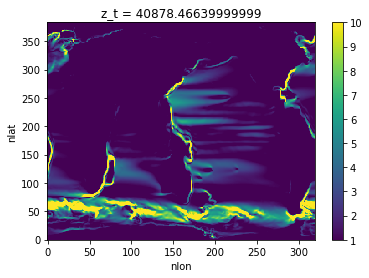

In [12]:
current_speed = np.sqrt(ds.UVEL**2 + ds.VVEL**2)
current_speed = xr.where(current_speed < current_speed_min, current_speed_min, current_speed)
current_speed = xr.where(current_speed > current_speed_max, current_speed_max, current_speed)

h = current_speed.isel(z_t=30).plot()

current_speed = current_speed.reset_index('z_t', drop=True)
current_speed

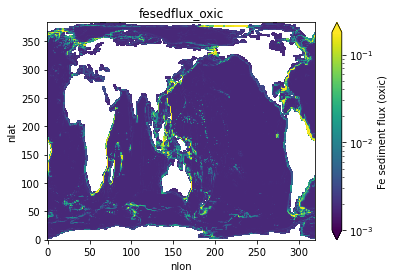

In [13]:
fesedflux_oxic = coef_fesedflux_current_speed2 * sedfrac_mod * current_speed**2
fesedflux_oxic = fesedflux_oxic * mmolm2yr_to_μmolm2d
fesedflux_oxic.name = 'Fe sediment flux (oxic)'
fesedflux_oxic.attrs['units'] = 'micromol m$^{-2}$ d$^{-1}$'
fesedflux_oxic.attrs['long_name'] = 'Fe sediment flux (oxic)'

plt.figure()
fesedflux_oxic.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-3, vmax=fesedflux_oxic.max()))
h = plt.title('fesedflux_oxic')

In [14]:
fesedflux_oxic_global = esmlab.statistics.weighted_sum(fesedflux_oxic, weights=ds.TAREA/cm2_per_m2, 
                                                         dim=('nlat', 'nlon')).sum('z_t')

fesedflux_oxic_global = fesedflux_oxic_global * mol_per_µmol / mol_per_Gmol * d_per_yr
print(f'Global integral of `fesedflux_oxic_global` = {fesedflux_oxic_global.values:0.4f} Gmol Fe/yr')


Global integral of `fesedflux_oxic_global` = 0.6356 Gmol Fe/yr


## Compute total

Global integral of `fesedflux_total_global` = 14.2238 Gmol Fe/yr


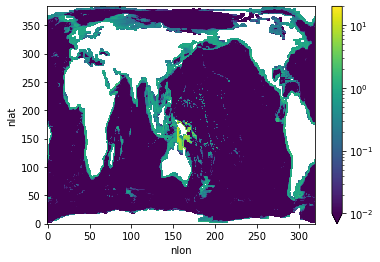

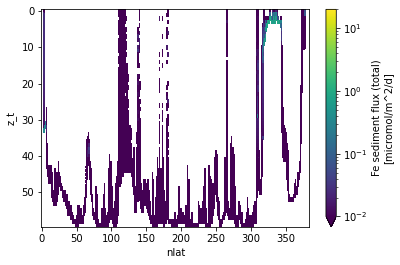

In [15]:
fesedflux_total = (fesedflux_oxic + fesedflux_reduce)
fesedflux_total.attrs['units'] = 'micromol/m^2/d'
fesedflux_total.attrs['long_name'] = 'Fe sediment flux (total)'

fesedflux_total_global = esmlab.statistics.weighted_sum(fesedflux_total, weights=ds.TAREA/cm2_per_m2, 
                                                         dim=('nlat', 'nlon')).sum('z_t')

fesedflux_total_global = fesedflux_total_global * mol_per_µmol / mol_per_Gmol * d_per_yr
print(f'Global integral of `fesedflux_total_global` = {fesedflux_total_global.values:0.4f} Gmol Fe/yr')


plt.figure()
fesedflux_total.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))

plt.figure()
fesedflux_total.isel(nlon=i_pacific).plot(yincrease=False, norm=colors.LogNorm(vmin=1e-2, vmax=20.))



## Construct output file

The model uses a scale factor when reading in the `fesedflux`:
`scale_factor = 1.1574e-6`; this converts from µmol/m^2/d to nmol/cm^2/s.

In [16]:
dso = xr.Dataset()

dso['FESEDFLUXIN'] = fesedflux_total
dso.FESEDFLUXIN.encoding = {'_FillValue': None, 'dtype': np.single}

dso['FESEDFLUXIN_reduce'] = fesedflux_reduce
dso.FESEDFLUXIN_reduce.encoding = {'_FillValue': None, 'dtype': np.single}

dso['FESEDFLUXIN_oxic'] = fesedflux_oxic
dso.FESEDFLUXIN_oxic.encoding = {'_FillValue': None, 'dtype': np.single}

for v in ['TAREA', 'TLONG', 'TLAT', 'KMT', 'z_t']:
    dso[v] = ds[v]
    dso.encoding['_FillValue'] = None
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by {id_string} on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
file_out = f'{util.dirout}/fesedflux_total_reduce_oxic_{dst_grid}.c{datestamp}.nc'

dso.to_netcdf(file_out)
util.ncks_fl_fmt64bit(file_out)

print(f'wrote: {file_out}')
dso.info()

wrote: /glade/work/mclong/cesm_inputdata/fesedflux_total_reduce_oxic_POP_gx1v7.c200618.nc
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	z_t = 60 ;

variables:
	float64 z_t(z_t) ;
		z_t:units = cm ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:positive = down ;
	float64 FESEDFLUXIN(z_t, nlat, nlon) ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe sediment flux (total) ;
	float64 FESEDFLUXIN_reduce(z_t, nlat, nlon) ;
		FESEDFLUXIN_reduce:units = micromol m$^{-2}$ d$^{-1}$ ;
	float64 FESEDFLUXIN_oxic(z_t, nlat, nlon) ;
		FESEDFLUXIN_oxic:units = micromol m$^{-2}$ d$^{-1}$ ;
		FESEDFLUXIN_oxic:long_name = Fe sediment flux (oxic) ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;
	float64 TLONG(nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	float64 TLAT(nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid la

## Compare with CESM2 forcing dataset

In [17]:
cesm2_file = f'{util.inputdata}/ocn/pop/gx1v6/forcing/fesedfluxTot_gx1v6_cesm2_2018_c180618.nc'
cesm2 = xr.open_dataset(cesm2_file).rename({'z': 'z_t', 'y': 'nlat', 'x': 'nlon'})

cesm2['z_t'] = pop_tools.get_grid('POP_gx1v7').z_t
cesm2['AREA_m2'] = pop_tools.get_grid('POP_gx1v7').TAREA * 1e-4
cesm2.FESEDFLUXIN.attrs['units'] = 'µmol/m^2/d'
cesm2

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    FESEDFLUXIN  (z_t, nlat, nlon) float32 ...
    AREA_m2      (nlat, nlon) float64 1.125e+09 1.125e+09 ... 7.432e+08

In [18]:
fesedflux_total_cesm2 = esmlab.statistics.weighted_sum(cesm2.FESEDFLUXIN, weights=cesm2.AREA_m2, 
                                                         dim=('nlat', 'nlon')).sum('z_t')
fesedflux_total_cesm2 = fesedflux_total_cesm2 * mol_per_µmol / mol_per_Gmol * d_per_yr

print(f'Global integral of `fesedflux_total_cesm2` = {fesedflux_total_cesm2.values:0.4f} Gmol Fe/yr')

Global integral of `fesedflux_total_cesm2` = 19.9526 Gmol Fe/yr


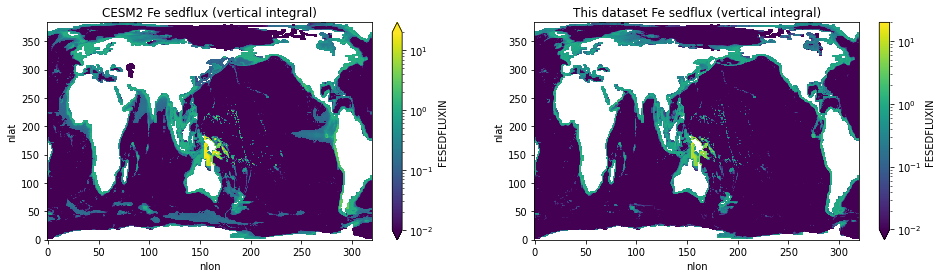

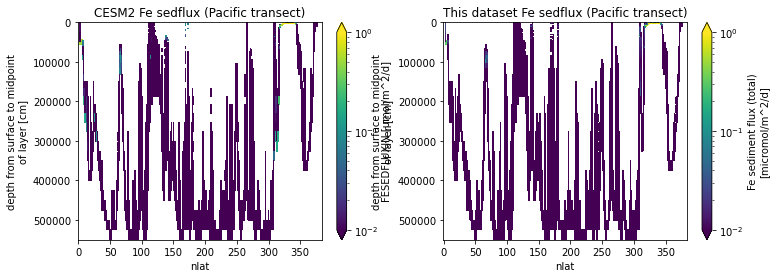

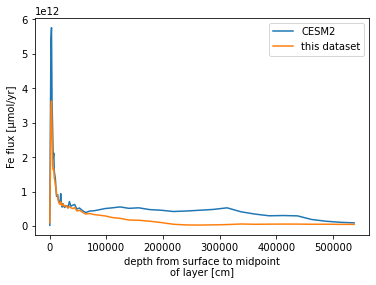

In [19]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
cesm2.FESEDFLUXIN.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))
plt.title('CESM2 Fe sedflux (vertical integral)')

ax = fig.add_subplot(1, 2, 2)
dso.FESEDFLUXIN.sum('z_t').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))
plt.title('This dataset Fe sedflux (vertical integral)')


fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
cesm2.FESEDFLUXIN.isel(nlon=200).plot(yincrease=False, norm=colors.LogNorm(vmin=1e-2, vmax=1.))
plt.title('CESM2 Fe sedflux (Pacific transect)')

ax = fig.add_subplot(1, 2, 2)
dso.FESEDFLUXIN.isel(nlon=i_pacific).plot(yincrease=False, norm=colors.LogNorm(vmin=1e-2, vmax=1.))
plt.title('This dataset Fe sedflux (Pacific transect)')

plt.figure()
esmlab.statistics.weighted_sum(cesm2.FESEDFLUXIN, weights=cesm2.AREA_m2, dim=('nlat', 'nlon')).plot(label='CESM2')
esmlab.statistics.weighted_sum(dso.FESEDFLUXIN, weights=ds.TAREA/cm2_per_m2, dim=('nlat', 'nlon')).plot(label='this dataset')
plt.ylabel('Fe flux [µmol/yr]')
plt.legend();

In [20]:
%load_ext watermark
%watermark --iversion -g  -m -v -u -d

numpy     1.18.1
esmlab    2019.4.27.post55
xarray    0.15.1
tqdm      4.45.0
pop_tools 0.0.post167
yaml      5.3.1
last updated: 2020-06-18 

CPython 3.7.6
IPython 7.13.0

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
Git hash   : 41cfb9957b578177e39fe0489171687407c91eaa
